In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
from data_utils import WoodDataset
from models import MBV2_CA
from torch.utils.data import DataLoader
import torchvision.models as models
from torch import nn
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from copy import deepcopy
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

from os import path
from tqdm.notebook import tqdm
import joblib
import wandb

In [99]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ivan/.netrc


True

In [6]:
train_val_test_split_params = {
    'test_size': 0.25,
    'valid_size': 0.25,
    'random_state': 42,
    'stratify': 'target'
}

stats_trans = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])

train_dataset = WoodDataset(
    img_dir='data', 
    is_test=False, 
    task_type='classification', 
    dataset_role='train', 
    train_val_test_split_params=train_val_test_split_params,
    img_transforms=stats_trans
)


means = []
stds = []
for idx in tqdm(range(len(train_dataset)), total=len(train_dataset)):
    img = train_dataset[idx]['image']
    means.append(torch.mean(img, dim=(1, 2)))
    stds.append(torch.std(img, dim=(1, 2)))

mean = torch.mean(torch.tensor([m.numpy() for m in means]), dim=0)
std = torch.mean(torch.tensor([s.numpy() for s in stds]), dim=0)

  0%|          | 0/266 [00:00<?, ?it/s]

/tmp/ipykernel_100145/1322741780.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  mean = torch.mean(torch.tensor([m.numpy() for m in means]), dim=0)


In [109]:
trans_with_aug = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
trans_without_aug = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [110]:
train_dataset = WoodDataset(
    img_dir='data', 
    is_test=False, 
    task_type='ranking', 
    dataset_role='train', 
    train_val_test_split_params=train_val_test_split_params,
    img_transforms=trans_with_aug
)
valid_dataset = WoodDataset(
    img_dir='data', 
    is_test=False, 
    task_type='ranking', 
    dataset_role='valid', 
    train_val_test_split_params=train_val_test_split_params,
    img_transforms=trans_with_aug
)
test_dataset = WoodDataset(
    img_dir='data', 
    is_test=False, 
    task_type='ranking', 
    dataset_role='test', 
    train_val_test_split_params=train_val_test_split_params,
    img_transforms=trans_without_aug
)
submission_dataset = WoodDataset(
    img_dir='data', 
    is_test=True, 
    task_type='ranking',
    img_transforms=trans_without_aug
)

In [145]:
batch_size = 32

train_preset = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0, 'drop_last': True}
test_preset = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'drop_last': False}

train_dataloader = DataLoader(train_dataset, **train_preset)
valid_dataloader = DataLoader(valid_dataset, **train_preset)
test_dataloader = DataLoader(test_dataset, **test_preset)
submission_dataloader = DataLoader(submission_dataset, **test_preset)

dataloaders = {
    'train': train_dataloader, 
    'valid': valid_dataloader, 
    'test':test_dataloader, 
    'subm': submission_dataloader
}

In [112]:
def layers_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        layers_freeze(child)
        
        
def layers_unfreeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = True
        layers_unfreeze(child)

In [113]:
torch.manual_seed(42)

In [114]:
model = models.mobilenet_v2(pretrained=True)
#layers_freeze(model)
model.classifier = nn.Sequential(
    model.classifier[0], 
    nn.Linear(model.classifier[1].in_features, 512, bias=True), 
    nn.ReLU6(), 
    nn.Linear(512, 2, bias=True),
    nn.Sigmoid()
)

In [115]:
lr = 1e-3

loss = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.MultiStepLR(optimizer, gamma=0.1, milestones=[5, 15, 30, 45])

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 10
#es_num = 15

train_epoch_losses = []
valid_epoch_losses = []
es_counter = 0

wandb.init(
    # Set the project where this run will be logged
    project="wood hack", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"experiment_0", 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 'MultiStepLR(optimizer, gamma=0.1, milestones=[5, 15, 30, 45])',
    "architecture": "mobilenetv2 ranking without freezing",
    "dataset": "ranking",
    "epochs": n_epochs,
    })
    
    
for epoch in range(n_epochs):
    #if epoch == 6:
    #    layers_unfreeze(model)
    #    optimizer = optim.Adam(model.parameters(), lr=lr)
    #    scheduler = lr_scheduler.MultiStepLR(optimizer, gamma=0.1, milestones=[10, 20, 30, 40])
    for sample, dataloader in dataloaders.items():
        if sample not in ['train', 'valid']:
            continue
        elif sample == 'train':
            model.train()
        elif sample == 'valid':
            model.eval()
        loss_val = 0
        obj_cnt = 0
        with tqdm(dataloader, unit="batch") as tqdm_dataloader:
            for batch in tqdm_train_dataloader:
                tqdm_dataloader.set_description(f"{sample} Epoch {epoch}")
                
                images = batch['image'].to(device)
                targets = batch['target'].to(device)
                
                batch_shape = images.shape[0]
                obj_cnt += batch_shape
                
                model.zero_grad()
                output = model(images)
                batch_loss = loss(output, targets)
                
                if sample == 'train':
                    batch_loss.backward()
                    optimizer.step()
                    
                batch_loss_val = batch_loss.detach().item()
                loss_val += batch_loss_val
                tqdm_dataloader.set_postfix(
                    batch_loss=batch_loss_val / batch_shape,
                    epoch_loss=loss_val / obj_cnt)
                wandb.log({f'batch_{sample}_loss': batch_loss_val / batch_shape})
        if sample == 'train':
            train_epoch_losses.append(loss_val / obj_cnt)
        elif sample == 'valid':
            valid_epoch_losses.append(loss_val / obj_cnt)
        wandb.log({f'epoch_{sample}_loss': loss_val / obj_cnt})
    now_time_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    torch.save(model.state_dict(),
               path.join(
                   'data',
                   'nn_chpt','mn2',
                   f'model_{epoch}_{now_time_str}_{round(train_epoch_losses[-1], 4)}_{round(valid_epoch_losses[-1], 4)}'))
wandb.finish()
print(np.argmin(valid_epoch_losses))

  0%|          | 0/8 [00:00<?, ?batch/s]

/home/ivan/Рабочий стол/wood_classification/data_utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'image': in_img, 'target': torch.tensor(target, dtype=torch.float), 'img_path': path}


  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

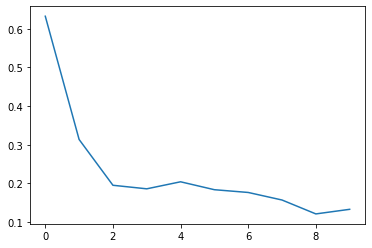

In [118]:
plt.plot(range(10), valid_epoch_losses)

In [142]:
with torch.no_grad():
    model.eval()
    with tqdm(test_dataloader, unit="batch") as tqdm_test_dataloader:
        valid_loss = 0
        valid_cnt = 0
        pred = []
        true = []
        img_path = []
        for batch in tqdm_test_dataloader:
            images = batch['image'].to(device)
            targets = batch['target'].to(device)
            output = model(images)
            output = np.argmax(np.hstack((
                np.ones((output.shape[0], 1))*0.1, 
                ((output.numpy()>=0.4)[:,0]*0.2).reshape(-1, 1), 
                ((output.numpy()>=0.4)[:,1]*0.3).reshape(-1, 1))
            ), axis=1)
            pred.extend(output.tolist())
            true.extend(targets.sum(dim=1).detach().numpy().tolist())
            img_path.extend(batch['img_path'])
test_df = pd.DataFrame({'true': true, 'pred': pred, 'img_path': img_path})

  0%|          | 0/134 [00:00<?, ?batch/s]

/home/ivan/Рабочий стол/wood_classification/data_utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'image': in_img, 'target': torch.tensor(target, dtype=torch.float), 'img_path': path}


In [146]:
print(classification_report(test_df.true, test_df.pred))

              precision    recall  f1-score   support

         0.0       1.00      0.41      0.58        17
         1.0       0.89      0.92      0.91        53
         2.0       0.88      0.98      0.93        64

    accuracy                           0.89       134
   macro avg       0.92      0.77      0.81       134
weighted avg       0.90      0.89      0.88       134



In [147]:
with torch.no_grad():
    model.eval()
    with tqdm(dataloaders['subm'], unit="batch") as tqdm_dataloader:
        valid_loss = 0
        valid_cnt = 0
        pred = []
        true = []
        img_path = []
        for batch in tqdm_dataloader:
            images = batch['image'].to(device)
            targets = batch['target'].to(device)
            output = model(images)
            output = np.argmax(np.hstack((
                np.ones((output.shape[0], 1))*0.1, 
                ((output.numpy()>=0.4)[:,0]*0.2).reshape(-1, 1), 
                ((output.numpy()>=0.4)[:,1]*0.3).reshape(-1, 1))
            ), axis=1)
            pred.extend(output.tolist())
            true.extend(targets.sum(dim=1).detach().numpy().tolist())
            img_path.extend(batch['img_path'])
test_df = pd.DataFrame({'true': true, 'pred': pred, 'img_path': img_path})

  0%|          | 0/249 [00:00<?, ?batch/s]

/home/ivan/Рабочий стол/wood_classification/data_utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'image': in_img, 'target': torch.tensor(target, dtype=torch.float), 'img_path': path}


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [35]:
test_df.pred.value_counts()

0    134
1     90
2     25
Name: pred, dtype: int64

In [36]:
backward_mapping = {0: 1, 1: 3, 2: 0}

test_df['id'] = test_df.img_path.map(lambda x: path.split(x)[-1].split('.')[0])
test_df['class'] = test_df.pred.map(lambda x: backward_mapping[x])

In [37]:
test_df[['id', 'class']].to_csv(path.join('data', 'mn_cls_99.csv'), index=False)

In [144]:
confusion_matrix(test_df.true, test_df.pred)

array([[ 7,  5,  5],
       [ 0, 49,  4],
       [ 0,  1, 63]])